## Predicting Employee Attrition: A Human Resources Solution
### Leonid Shpaner, Payal Bhavesh Muni, and Sean Torres

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split

### Reading in and inspecting the dataframe

In [2]:
# read in the dataset from excel
hr = pd.read_excel('HR_Employee_Data.xlsx')

In [3]:
# inspect the first 5 rows of the dataset
hr.head()

,Emp_Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,IND02438,0.38,0.53,2,157,3,0,1,0,sales,low
1,IND28133,0.80,0.86,5,262,6,0,1,0,sales,medium
2,IND07164,0.11,0.88,7,272,4,0,1,0,sales,medium
3,IND30478,0.72,0.87,5,223,5,0,1,0,sales,low
4,IND24003,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# inspect # of rows and columns
numb_rows = hr.shape[0]
numb_col = hr.shape[1]

print('Number of Rows:', numb_rows)
print('Number of Rows:', numb_col)

Number of Rows: 14999
Number of Rows: 11


## Exploratory Data Analysis (EDA)

**Renaming Columns**

In [5]:
# Renaming some columns
hr = hr.rename(columns={'Emp_Id':'Employee_ID',
                        'average_montly_hours':
                        'average_monthly_hours',
                        'left':'Attrition'})
# Dummy Target Variable in a new column
hr['Status'] = hr['Attrition'].map({1:'left', 0:'stayed'})

In [6]:
print("\033[1m"+'Data Types'+"\033[1m")
hr.dtypes

Data Types


Employee_ID               object
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
time_spend_company         int64
Work_accident              int64
Attrition                  int64
promotion_last_5years      int64
Department                object
salary                    object
Status                    object
dtype: object

In [7]:
# check for unique employee ID number
hr['Employee_ID'].nunique()

14999

**There are 14,999 unique employees in this dataset.**

In [8]:
# inspect dataset for missing values
print("\033[1m"+'Null Value Counts'+"\033[1m")
hr.isnull().sum()

Null Value Counts


Employee_ID              0
satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
Attrition                0
promotion_last_5years    0
Department               0
salary                   0
Status                   0
dtype: int64

Employee Data: Correlation Matrix


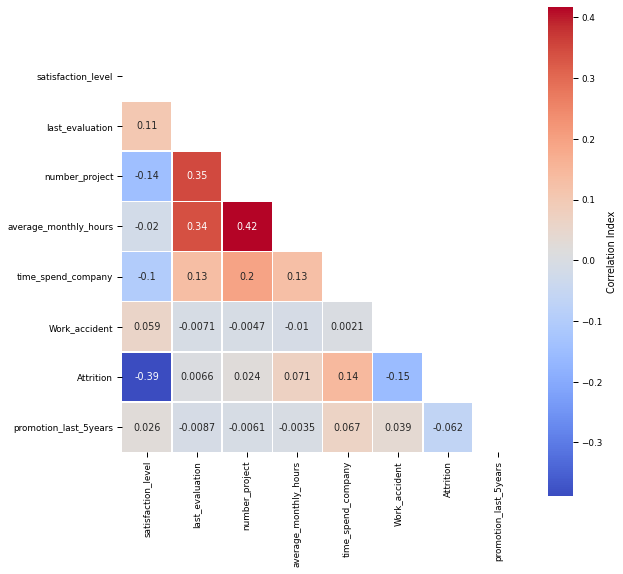

In [9]:
print("\033[1m"+'Employee Data: Correlation Matrix'+"\033[1m")
corr = hr.corr()
# sns.heatmap(corr, annot=True, mask=matrix)
sns.set_context('paper', font_scale=1)
plt.figure(figsize=(9,9))
plt.tight_layout(pad = 10, w_pad=10, h_pad=10)
matrix = np.triu(corr)
sns.heatmap(hr.corr(method='pearson'), annot=True, 
            linewidths=.5, cmap="coolwarm", mask=matrix,
            square = True, cbar_kws={'label': 'Correlation Index'})
plt.show()

**A moderate correlation of *r* = 0.42 exists between 'average_monthly_hours' and 'number_project.' 'Number_project' is less moderately correlated to 'last_evaluation' at *r* = 0.35. 'Average_monthly_hours' is slightly less moderately correlated to 'last_evaluation' at *r* = 0.34. 'Satisfaction_level' is also moderately correlated with the target 'Attrition' with a correlation coefficient *r* = -0.39.**
    
**From this analysis and the ensuing scatter plots below, it can be said that there exists a negative relationship between employee satisfaction and attrition. There exist almost no relationships between attrition and  other predictors, except 'time_spend_company', where *r* = 0.14, and 'work_accident', where *r* = -0.15.**

Selected Scatter Plots from Four Highest Correlated Predictors


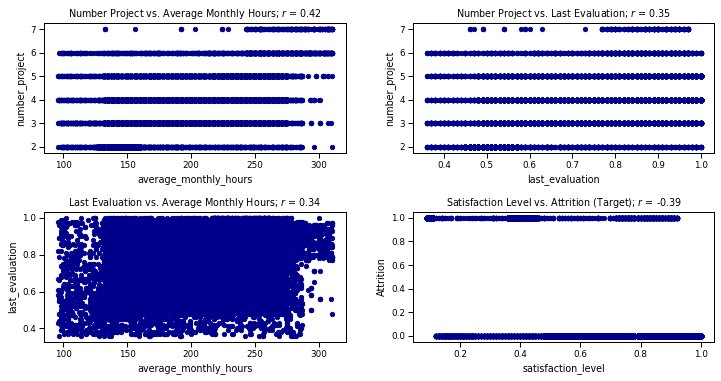

In [10]:
print("\033[1m"+'Selected Scatter Plots from \
Four Highest Correlated Predictors'+"\033[1m")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
flat = axes.flatten()
fig.tight_layout(w_pad=4, h_pad=4)
hr.plot.scatter(x='average_monthly_hours',
                y='number_project',
                c='DarkBlue',
                ax=flat[0])
corr1 = round(np.corrcoef(hr.average_monthly_hours,
                                hr.number_project)[0,1],2)
flat[0].set_title('Number Project vs. Average Monthly Hours;'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr1))

hr.plot.scatter(x='last_evaluation',
                y='number_project',
                c='DarkBlue',
                ax=flat[1])
corr2 = round(np.corrcoef(hr.last_evaluation,
                                hr.number_project)[0,1],2)
flat[1].set_title('Number Project vs. Last Evaluation;'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr2))
hr.plot.scatter(x='average_monthly_hours',
                y='last_evaluation',
                c='DarkBlue',
                ax=flat[2])
corr3 = round(np.corrcoef(hr.average_monthly_hours,
                                hr.last_evaluation)[0,1],2)
flat[2].set_title('Last Evaluation vs. Average Monthly Hours;'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr3))
hr.plot.scatter(x='satisfaction_level',
                y='Attrition',
                c='DarkBlue',
                ax=flat[3])
corr4 = round(np.corrcoef(hr.satisfaction_level,
                                hr.Attrition)[0,1],2)
flat[3].set_title('Satisfaction Level vs. Attrition (Target);'
                  ' $\mathit{r}$ = ' + "{:.2f}".format(corr4))
plt.show()

In [11]:
print("\033[1m"+'Employee Summary Statistics'+"\033[1m")

def summary_by_var():
    pd.options.display.float_format = '{:,.2f}'.format
    summary = hr.describe().loc[['mean', 'std', 'min', 
                                      '25%', '50%', '75%', 'max']].T
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = summary.rename(columns = column_rename)
    return dfsummary

summary_by_var()

Employee Summary Statistics


,Mean,Standard Deviation,Minimum,25%,50%,75%,Maximum
satisfaction_level,0.61,0.25,0.09,0.44,0.64,0.82,1.00
last_evaluation,0.72,0.17,0.36,0.56,0.72,0.87,1.00
number_project,3.80,1.23,2.00,3.00,4.00,5.00,7.00
average_monthly_hours,201.05,49.94,96.00,156.00,200.00,245.00,310.00
time_spend_company,3.50,1.46,2.00,3.00,3.00,4.00,10.00
Work_accident,0.14,0.35,0.00,0.00,0.00,0.00,1.00
Attrition,0.24,0.43,0.00,0.00,0.00,0.00,1.00
promotion_last_5years,0.02,0.14,0.00,0.00,0.00,0.00,1.00


In [12]:
print("\033[1m"+'Average Monthly Hours: \
Summary Statistics by Department'+"\033[1m")

def summary_by_job():
    pd.options.display.float_format = '{:,.2f}'.format
    new = hr.groupby('Department')['average_monthly_hours']\
    .agg(["mean", "median", "std", "min", "max"])
    new.loc['Total'] = new.sum(numeric_only=True, axis=0)
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = new.rename(columns = column_rename)
    new
    return dfsummary

summary_by_job()

Average Monthly Hours: Summary Statistics by Department


,Mean,Median,Standard Deviation,Minimum,Maximum
Department,,,,,
IT,202.22,199.00,50.69,96.00,308.00
RandD,200.80,200.00,49.25,98.00,308.00
accounting,201.16,199.00,51.11,97.00,310.00
hr,198.68,197.00,50.37,98.00,310.00
management,201.25,204.00,47.38,97.00,307.00
marketing,199.39,198.00,49.36,96.00,310.00
product_mng,199.97,198.00,50.11,98.00,310.00
sales,200.91,201.00,49.56,96.00,310.00
support,200.76,200.00,50.02,96.00,310.00


In [13]:
print("\033[1m"+'Satisfaction by Department: \
Summary Statistics'+"\033[1m")

def satisfaction_by_job():
    pd.options.display.float_format = '{:,.2f}'.format
    new2 = hr.groupby('Department')['satisfaction_level']\
    .agg(["mean", "median", "std", "min", "max"])
    new2.loc['Total'] = new2.sum(numeric_only=True, axis=0)
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = new2.rename(columns = column_rename)
    new2
    return dfsummary
satisfaction_by_job()

Satisfaction by Department: Summary Statistics


,Mean,Median,Standard Deviation,Minimum,Maximum
Department,,,,,
IT,0.62,0.66,0.25,0.09,1.00
RandD,0.62,0.65,0.25,0.09,1.00
accounting,0.58,0.61,0.26,0.09,1.00
hr,0.60,0.61,0.25,0.09,1.00
management,0.62,0.66,0.23,0.09,1.00
marketing,0.62,0.64,0.24,0.09,1.00
product_mng,0.62,0.64,0.24,0.09,1.00
sales,0.61,0.64,0.25,0.09,1.00
support,0.62,0.65,0.25,0.09,1.00


In [14]:
print("\033[1m"+'Attrition Outcome by Department'+"\033[1m")

def ret_by_dept():
    dept_ret_stayed = hr.loc[hr.Status == 'stayed'].groupby\
    (['Department'])[['Status']].count()
    dept_ret_stayed.rename(columns={'Status':'Stayed'}, inplace=True)
    dept_ret_left = hr.loc[hr.Status == 'left'].groupby\
    (['Department'])[['Status']].count()
    dept_ret_left.rename(columns={'Status':'Left'}, inplace=True)
    merged_df = pd.concat([dept_ret_stayed, dept_ret_left], axis = 1)
    merged_df.loc['Total'] = merged_df.sum(numeric_only=True, axis=0)
    merged_df['# of Employees'] = merged_df.sum(axis=1)
    merged_df['% Retention'] = round((merged_df['Stayed'] / \
    (merged_df['Stayed'] + merged_df['Left']))* 100, 2)
    return merged_df.style.format("{:,.0f}")

ret_by_dept()

Attrition Outcome by Department


,Stayed,Left,# of Employees,% Retention
Department,,,,
IT,954,273,"1,227",78
RandD,666,121,787,85
accounting,563,204,767,73
hr,524,215,739,71
management,539,91,630,86
marketing,655,203,858,76
product_mng,704,198,902,78
sales,"3,126","1,014","4,140",76
support,"1,674",555,"2,229",75


**The ensuing bar graphs measure interdepartmental attrition. For example, sales has the highest attrition (employees who left), but also the highest retention (those who stayed). Normalizing this dsitribution, we see an uptick in hr department attrition in terms of rate, but a higher retention rate too. Sales, support, and technical departments remain at about equal attrition rates, and high retention across the board.**

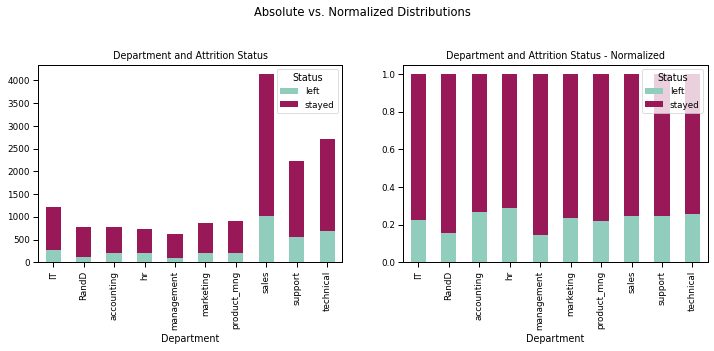

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
fig.suptitle('Absolute vs. Normalized Distributions')

crosstabdept = pd.crosstab(hr['Department'],hr['Status'])
crosstabdeptnorm = crosstabdept.div(crosstabdept.sum(1), axis = 0)

plotdest = crosstabdept.plot(kind='bar', stacked = True, 
                            title = 'Department and Attrition Status', 
                            ax = ax1, color = ['#90CDBC', '#991857'])

plotdeptnorm = crosstabdeptnorm.plot(kind='bar', stacked = True, 
                                     title = 'Department and'
                                     ' Attrition Status - Normalized', 
                                     ax = ax2, color = ['#90CDBC', 
                                                        '#991857'])

**The ensuing bar graphs measure attrition by salary. For example, there exists a higher prevalance in lower salaries than medium and higher salaries, respectively. Among the lower salaries, more employees stayed within the company than those who left. Normalizing the distribution, we see the same trends; however, in terms of attrition rates, the lowest among the three categories is evident in the higher salaries. Lower salaries show the highest attrition rate, and medium salaries follow.**

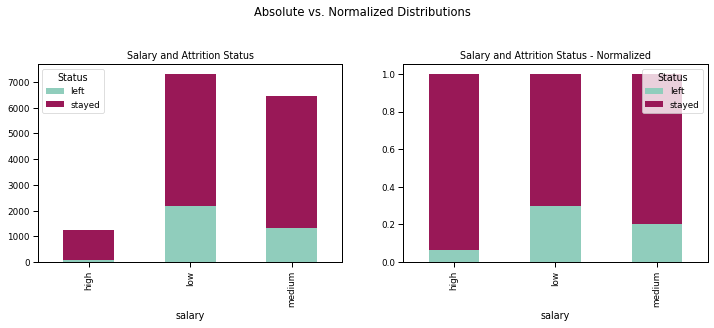

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
fig.suptitle('Absolute vs. Normalized Distributions')

crosstabsal = pd.crosstab(hr['salary'],hr['Status'])
crosstabsalnorm = crosstabsal.div(crosstabsal.sum(1), axis = 0)

plotdest = crosstabsal.plot(kind='bar', stacked = True, 
                            title = 'Salary and Attrition Status', 
                            ax = ax1, color = ['#90CDBC', '#991857'])

plotsalnorm = crosstabsalnorm.plot(kind='bar', stacked = True, 
                                     title = 'Salary and Attrition' 
                                     ' Status - Normalized', 
                                     ax = ax2, color = ['#90CDBC', 
                                                        '#991857'])

Boxplot Distributions


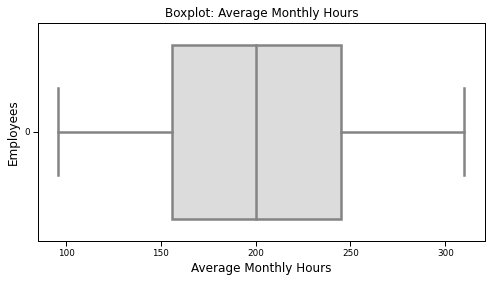

The first quartile is 156.0. 
The third quartile is 245.0. 
The IQR is 89.0.
The mean is 201.05.
The standard deviation is 49.94.
The median is 200.0.


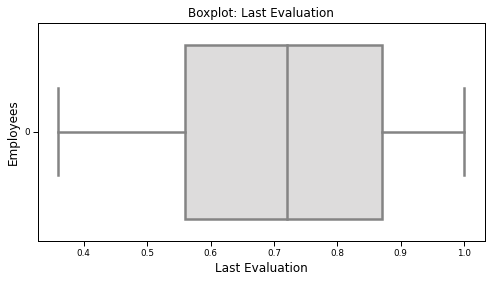

The first quartile is 0.56. 
The third quartile is 0.87. 
The IQR is 0.31.
The mean is 0.72.
The standard deviation is 0.17.
The median is 0.72.


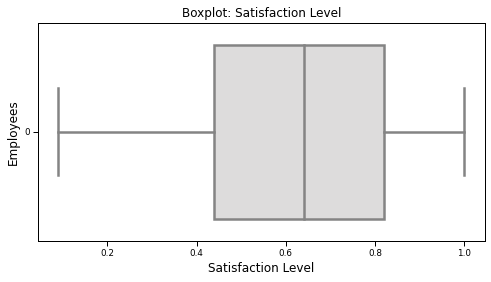

The first quartile is 0.44. 
The third quartile is 0.82. 
The IQR is 0.38.
The mean is 0.61.
The standard deviation is 0.25.
The median is 0.64.


In [17]:
print("\033[1m"+'Boxplot Distributions'+"\033[1m")
# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (8,4))
plt.title ('Boxplot: Average Monthly Hours',
          fontsize=12)
plt.xlabel('Average Monthly Hours', fontsize=12)
plt.ylabel('Employees', fontsize=12)

sns.boxplot(data=hr['average_monthly_hours'], 
            palette="coolwarm", orient='h', linewidth=2.5)
plt.show()

# Computing IQR
Q1 = hr['average_monthly_hours'].quantile(0.25)
Q3 = hr['average_monthly_hours'].quantile(0.75)
IQR = Q3-Q1

# Computing Summary Statistics
mean_1 = round(hr['average_monthly_hours'].mean(),2)
std_1 = round(hr['average_monthly_hours'].std(),2)
median_1 = round(hr['average_monthly_hours'].median(),2)
print('The first quartile is %s. '%Q1)
print('The third quartile is %s. '%Q3)
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s.'%mean_1)
print('The standard deviation is %s.'%std_1)
print('The median is %s.'%median_1)

# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (8,4))
plt.title ('Boxplot: Last Evaluation',
          fontsize=12)
plt.xlabel('Last Evaluation', fontsize=12)
plt.ylabel('Employees', fontsize=12)

sns.boxplot(data=hr['last_evaluation'], 
            palette="coolwarm", orient='h', linewidth=2.5)
plt.show()

# Computing IQR
Q1 = hr['last_evaluation'].quantile(0.25)
Q3 = hr['last_evaluation'].quantile(0.75)
IQR = Q3-Q1

# Computing Summary Statistics
mean_1 = round(hr['last_evaluation'].mean(),2)
std_1 = round(hr['last_evaluation'].std(),2)
median_1 = round(hr['last_evaluation'].median(),2)
print('The first quartile is %s. '%Q1)
print('The third quartile is %s. '%Q3)
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s.'%mean_1)
print('The standard deviation is %s.'%std_1)
print('The median is %s.'%median_1)

# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (8,4))
plt.title ('Boxplot: Satisfaction Level',
          fontsize=12)
plt.xlabel('Satisfaction Level', fontsize=12)
plt.ylabel('Employees', fontsize=12)

sns.boxplot(data=hr['satisfaction_level'], 
            palette="coolwarm", orient='h', linewidth=2.5)
plt.show()

# Computing IQR
Q1 = hr['satisfaction_level'].quantile(0.25)
Q3 = hr['satisfaction_level'].quantile(0.75)
IQR = Q3-Q1

# Computing Summary Statistics
mean_1 = round(hr['satisfaction_level'].mean(),2)
std_1 = round(hr['satisfaction_level'].std(),2)
median_1 = round(hr['satisfaction_level'].median(),2)
print('The first quartile is %s. '%Q1)
print('The third quartile is %s. '%Q3)
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s.'%mean_1)
print('The standard deviation is %s.'%std_1)
print('The median is %s.'%median_1)


Histogram Distribution


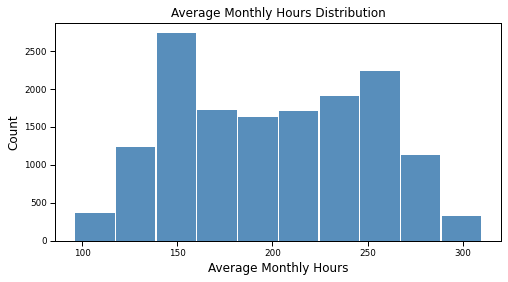

The first quartile is 156.0. 
The third quartile is 245.0. 
The IQR is 89.0.
The mean is 201.05.
The standard deviation is 49.94.
The median is 200.0.


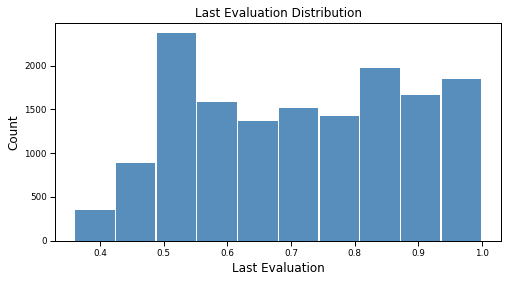

The first quartile is 0.56. 
The third quartile is 0.87. 
The IQR is 0.31.
The mean is 0.72.
The standard deviation is 0.17.
The median is 0.72.


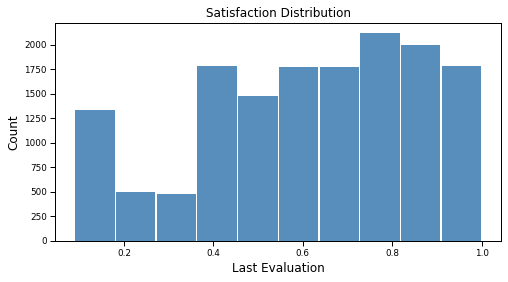

The first quartile is 0.44. 
The third quartile is 0.82. 
The IQR is 0.38.
The mean is 0.61.
The standard deviation is 0.25.
The median is 0.64.


In [18]:
print("\033[1m"+'Histogram Distribution'+"\033[1m")
# Plotting a histogram to show distribution
fig = plt.figure(figsize = (8,4))
plt.hist(hr['average_monthly_hours'], bins=10, 
         color='steelblue', alpha=0.9, rwidth=.97)
plt.title ('Average Monthly Hours Distribution', fontsize=12)
plt.xlabel('Average Monthly Hours', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.show()

# Computing IQR
Q1 = hr['average_monthly_hours'].quantile(0.25)
Q3 = hr['average_monthly_hours'].quantile(0.75)
IQR = Q3-Q1

# Computing Summary Statistics
mean_1 = round(hr['average_monthly_hours'].mean(),2)
std_1 = round(hr['average_monthly_hours'].std(),2)
median_1 = round(hr['average_monthly_hours'].median(),2)
print('The first quartile is %s. '%Q1)
print('The third quartile is %s. '%Q3)
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s.'%mean_1)
print('The standard deviation is %s.'%std_1)
print('The median is %s.'%median_1)

fig = plt.figure(figsize = (8,4))
plt.hist(hr['last_evaluation'], bins=10, 
         color='steelblue', alpha=0.9, rwidth=.97)
plt.title ('Last Evaluation Distribution', fontsize=12)
plt.xlabel('Last Evaluation', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.show()

# Computing IQR
Q1_1 = hr['last_evaluation'].quantile(0.25)
Q3_1 = hr['last_evaluation'].quantile(0.75)
IQR_1 = Q3_1-Q1_1

# Computing Summary Statistics
mean_1_1 = round(hr['last_evaluation'].mean(),2)
std_1_1 = round(hr['last_evaluation'].std(),2)
median_1_1 = round(hr['last_evaluation'].median(),2)
print('The first quartile is %s. '%Q1_1)
print('The third quartile is %s. '%Q3_1)
print('The IQR is %s.'%round(IQR_1,2))
print('The mean is %s.'%mean_1_1)
print('The standard deviation is %s.'%std_1_1)
print('The median is %s.'%median_1_1)

fig = plt.figure(figsize = (8,4))
plt.hist(hr['satisfaction_level'], bins=10, 
         color='steelblue', alpha=0.9, rwidth=.97)
plt.title ('Satisfaction Distribution', fontsize=12)
plt.xlabel('Last Evaluation', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.show()

# Computing IQR
Q1_2 = hr['satisfaction_level'].quantile(0.25)
Q3_2 = hr['satisfaction_level'].quantile(0.75)
IQR_2 = Q3_2-Q1_2

# Computing Summary Statistics
mean_1_2 = round(hr['satisfaction_level'].mean(),2)
std_1_2 = round(hr['satisfaction_level'].std(),2)
median_1_2 = round(hr['satisfaction_level'].median(),2)
print('The first quartile is %s. '%Q1_2)
print('The third quartile is %s. '%Q3_2)
print('The IQR is %s.'%round(IQR_2,2))
print('The mean is %s.'%mean_1_2)
print('The standard deviation is %s.'%std_1_2)
print('The median is %s.'%median_1_2)

**All of the examined distributions are normal.**

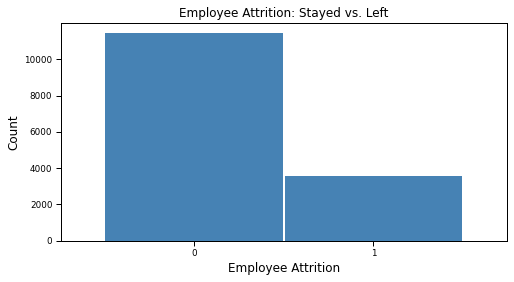

# of Employees that Stayed: 11428
# of Employees that Left: 3571
Attrition: 0.24


In [19]:
attrition_count = hr['Attrition'].value_counts()
fig = plt.figure(figsize=(8,4))
attrition_count.plot.bar(x ='lab', y='val', rot=0, width=0.99, 
                         color="steelblue")
plt.title ('Employee Attrition: Stayed vs. Left', fontsize=12)
plt.xlabel('Employee Attrition', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.show()

attrition_yes = attrition_count[1]
attrition_no = attrition_count[0]
attrition_rate = attrition_yes/(attrition_no + attrition_yes)

print('# of Employees that Stayed:', attrition_no)
print('# of Employees that Left:', attrition_yes)
print('Attrition:', round(attrition_rate,2))

## Pre-Processing

In [20]:
hr['salary_level'] = hr['salary'].map({'low':1,
                                       'medium':2, 
                                       'high':3})
# drop unnecessary columns
hr=hr.drop(columns=['Employee_ID','salary','Status', 'Department'])

**Generalized Linear Model - Logistic Regression Baseline**

$$y = \beta_0 + \beta_1x_1 +\beta_2x_2 +\cdots+\beta_px_p + \varepsilon$$

**Logistic Regression - Parametric Form**

$$p(y) = \frac{\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}{1+\text{exp}(\beta_0+\beta_1x_1+\beta_2x_2+\cdot\cdot\cdot+\beta_px_p)}  + \varepsilon$$

**Logistic Regression - Descriptive Form**

$$\hat{p}(y) = \frac{\text{exp}(b_0+b_1x_1+b_2x_2+\cdot\cdot\cdot+b_px_p)}{1+\text{exp}(b_0+b_1x_1+b_2x_2+\cdot\cdot\cdot+b_px_p)}$$

In [21]:
X = hr.drop(columns=['Attrition'])
X = sm.add_constant(X)
y = pd.DataFrame(hr[['Attrition']])
log_results = sm.Logit(y,X, random_state=42).fit()
log_results.summary()

Optimization terminated successfully.
         Current function value: 0.431823
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                14999
Model:                          Logit   Df Residuals:                    14990
Method:                           MLE   Df Model:                            8
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                  0.2132
Time:                        08:59:18   Log-Likelihood:                -6476.9
converged:                       True   LL-Null:                       -8232.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.2098      0.129      9.382      0.000       0.957       1.463
satisfaction_level       -4.1235      0.098    -42.285      0.000      -4.315      -3.932
last_evaluation           0.7249      0.148      4.885      0.000       0.434       1.016
number_project           -0.3110      0.021    -14.695      0.000      -0.352      -0.270
average_monthly_hours     0.0044      0.001      8.647      0.000       0.003       0.005
time_spend_company        0.2558      0.015     16.793      0.000       0.226       0.286
Work_accident            -1.5373      0.089    -17.183      0.000      -1.713      -1.362
promotion_last_5years    -1.5219      0.256     -5.935      0.000      -2.024      -1.019
salary_level             -0.7053      0.038    -18.654      0.000      -0.779      -0.631
=========================================================================================
"""

All of the independent variables are statisticall significant at the $\alpha$ = 0.05 level.

## Train_Test_Validation Split

In [22]:
size_train = round(6000/14999,2)
size_valid = round(5230/14999,2)
size_test = 500/2000
print('training size:', size_train)
print('validation size:', size_valid)
print('test size:', size_test)

training size: 0.4
validation size: 0.35
test size: 0.25


In [23]:
train, test = train_test_split(hr, train_size=6000, 
                               random_state=42)
valid, test = train_test_split(test, train_size=5230, 
                               random_state=42)
# confirm dimensions (size of newly partioned data)
print('Training:',len(train))
print('Validation:', len(valid))
print('Test:', len(test))

Training: 6000
Validation: 5230
Test: 3769


In [24]:
X_var = list(hr.columns)
target ='Attrition'
X_var.remove(target)
X_train = train[X_var]
y_train = train[target]
X_test = test[X_var] 
y_test = test[target]
X_valid = valid[X_var]
y_valid = valid[target]

## Modeling